In [54]:
import pandas as pd
import numpy as np
import json
from ast import literal_eval
import matplotlib.pyplot as plt
from datetime import datetime
import collections, functools, operator
import re

### The cell below load the Safegraph data and parse them

- Now itliteral_eval up for NYC (Bronx, Kings, New York, Queens, Richmond counties)
- The three datasets are for 2020/04, 2019/04 and 2020/10
- The files are exported to *csv.tar.gz in the datasets directory
- DO NOT run the following cell if you do not want to reparse the data
- For futher data explorations just use the *csv.tar.gz in the datasets directory

In [55]:
def parseData(year, month, state, counties, city):
    # For SafeGraph PlaceID to county conversion
    df_CBG = pd.read_csv('../datasets/placeToCBGMay/placeCountyCBG.csv')
    
    df_1 = pd.read_csv('../datasets/Places_Patterns/'+year+'/'+month+'/patterns-part1.csv.gz', compression='gzip')
    df_2 = pd.read_csv('../datasets/Places_Patterns/'+year+'/'+month+'/patterns-part2.csv.gz', compression='gzip')
    df_3 = pd.read_csv('../datasets/Places_Patterns/'+year+'/'+month+'/patterns-part3.csv.gz', compression='gzip')
    df_4 = pd.read_csv('../datasets/Places_Patterns/'+year+'/'+month+'/patterns-part4.csv.gz', compression='gzip')
    df_T = pd.concat([df_1, df_2, df_3, df_4])

    df_TC = pd.merge(df_CBG[df_CBG['state']==state], df_T[df_T['region']==state], on='safegraph_place_id')
    df_TC['countyName'] = df_TC['countyName'].apply(lambda x: x[:-7])

    df_F = df_TC[df_TC['countyName'].isin(counties)]
    df_F.drop(columns=['countyFIPS', 'stateFIPS', 'CBGFIPS', 'region', 'safegraph_brand_ids'], inplace=True)
    df_F.reset_index(drop=True, inplace=True)
    df_F.to_csv('../datasets/'+city+'/'+city+'_'+year+'_'+month+'.csv.tar.gz', index=False, compression='gzip')
    
    return df_F

def parseCore(year, month, state, counties, city):
    # For SafeGraph PlaceID to county conversion
    df_CBG = pd.read_csv('../datasets/placeToCBGMay/placeCountyCBG.csv')
    
    df_1 = pd.read_csv('../datasets/Core/'+year+'/'+month+'/core_poi-part1.csv.gz', compression='gzip')
    df_2 = pd.read_csv('../datasets/Core/'+year+'/'+month+'/core_poi-part2.csv.gz', compression='gzip')
    df_3 = pd.read_csv('../datasets/Core/'+year+'/'+month+'/core_poi-part3.csv.gz', compression='gzip')
    df_4 = pd.read_csv('../datasets/Core/'+year+'/'+month+'/core_poi-part4.csv.gz', compression='gzip')
    df_5 = pd.read_csv('../datasets/Core/'+year+'/'+month+'/core_poi-part5.csv.gz', compression='gzip')
    df_T = pd.concat([df_1, df_2, df_3, df_4, df_5])

    df_TC = pd.merge(df_CBG[df_CBG['state']==state], df_T[df_T['region']==state], on='safegraph_place_id')
    df_TC['countyName'] = df_TC['countyName'].apply(lambda x: x[:-7])

    df_F = df_TC[df_TC['countyName'].isin(counties)]
    df_F.drop(columns=['countyFIPS', 'stateFIPS', 'CBGFIPS', 'phone_number', 'iso_country_code', 'region', 'safegraph_brand_ids'], inplace=True)
    df_F.reset_index(drop=True, inplace=True)
    df_F.to_csv('../datasets/'+city+'/Core-'+city+'_'+year+'_'+month+'.csv.tar.gz', index=False, compression='gzip')
    return df_F

 
def getCity(state, counties, city):
    df_dict = {}
    for year in ['2019', '2020']:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            df_dict[year+'_'+month] = parseData(year, month, state, counties, city)
    
    for year in ['2021']:
        for month in ['01', '02', '03', '04']:
            df_dict[year+'_'+month] = parseData(year, month, state, counties, city)

    dfC = parseCore('2020', '04', state, counties, city)
    return df_dict, dfC

## New York

In [56]:
parsedata = True
if parsedata:
    getCity('NY', ['Bronx', 'Kings', 'New York', 'Queens', 'Richmond'], 'NYC')

### Load the data

In [41]:
def slicePlaceType(df_test, df_base, place_types_list=[]):
    dict_df = {}
    for placeType in place_types_list:
        df = df_test[df_test['top_category'].str.contains(placeType, na=False)][['safegraph_place_id', 'top_category', 'sub_category', 'naics_code', 'popularity_by_day']]
        df = pd.merge(df, df_base[df_base['top_category'].str.contains(placeType, na=False)][['safegraph_place_id', 'popularity_by_day']], on='safegraph_place_id')
        df['popularity_by_day_x'] = df['popularity_by_day_x'].apply(lambda x: np.sum(list(literal_eval(x).values())))
        df['popularity_by_day_y'] = df['popularity_by_day_y'].apply(lambda x: np.sum(list(literal_eval(x).values())))
        df['occupancy'] = df['popularity_by_day_x']/df['popularity_by_day_y']*100
        dict_df[placeType] = df
    
    return dict_df

def make_plots(dict_df, keys, place_types_list):
    for pl_key in place_types_list:
        plt.figure(figsize=(18,6))
        for key in keys[1:-2]:
            tag = [datetime.strptime(key, '%Y_%m').strftime('%B %Y') for key in keys]
            plt.hist(dict_df[key][pl_key][dict_df[key][pl_key]['occupancy'] < 300].occupancy, bins=100, label=tag, histtype='step', linewidth=3)
        plt.hist(dict_df['2020_03'][pl_key][dict_df['2020_03'][pl_key]['occupancy'] < 300].occupancy, bins=100, label=tag, linewidth=3, alpha=0.7)
        plt.hist(dict_df['2020_04'][pl_key][dict_df['2020_04'][pl_key]['occupancy'] < 300].occupancy, bins=100, label=tag, linewidth=3, alpha=0.7)
        plt.xlabel('% occupancy (baseline: April 2019)', fontsize=16)
        plt.ylabel('number of places', fontsize=16)
        plt.title(pl_key + ' in New York City', fontsize=18)
        plt.grid(':', alpha=0.7)
        plt.xlim((-0.1, 200))
        plt.legend()
        plt.show()

In [ ]:
keys = ['2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10', '2019_11', '2019_12', '2020_01', '2020_02', '2020_03', '2020_04']
dict_df = {}
dict_df_NYC = {}

for key in keys:
    dict_df[key] = pd.read_csv('../datasets/NYC_'+key+'.csv.tar.gz', compression='gzip')
    
dfC_2020_04 = pd.read_csv('../datasets/Core-NYC_2020_04.csv.tar.gz', compression='gzip')

for key in keys:
    dict_df_NYC[key] = pd.merge(dfC_2020_04[dfC_2020_04['city']=='New York'][['safegraph_place_id', 'top_category', 'sub_category', 'naics_code']],
                                dict_df[key][dict_df[key]['city']=='New York'], on='safegraph_place_id')
    

dump = False
if dump:
    with open('../datasets/place_types.json', 'w') as f:
        json.dump(pd.DataFrame(np.sort(dict_df_NYC[keys[0]]['top_category'].dropna().unique()), columns=["place_type"]).to_dict(orient='dict'), f, indent=4)
    
with open('../datasets/place_types.json', 'r') as f:
    place_types = json.load(f)
    

place_types_list = ['Restaurants', 'Grocery', 'Clothing Stores']
dict_df_analysis = {}
for key in keys[1:]:
    dict_df_analysis[key] = slicePlaceType(dict_df_NYC[key], dict_df_NYC['2019_04'], place_types_list)

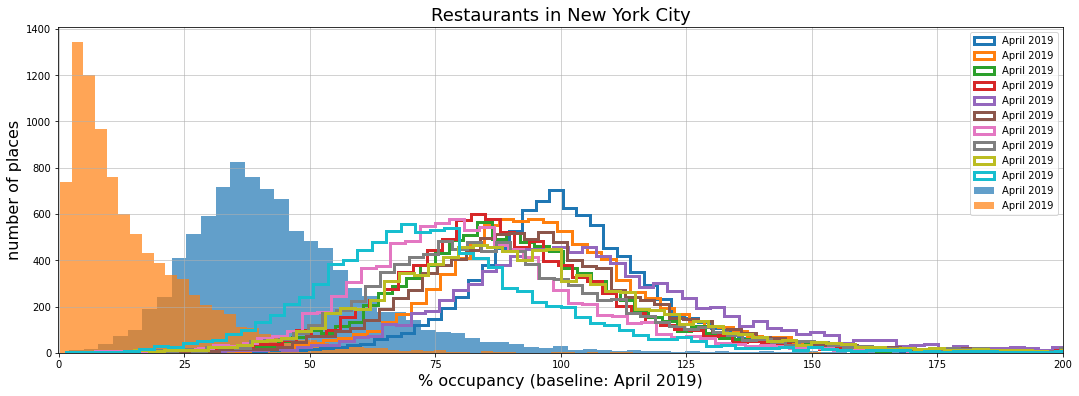

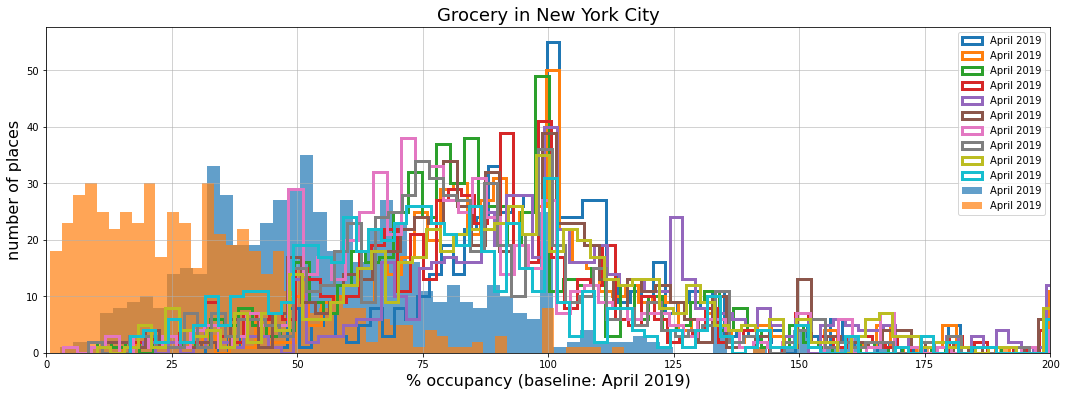

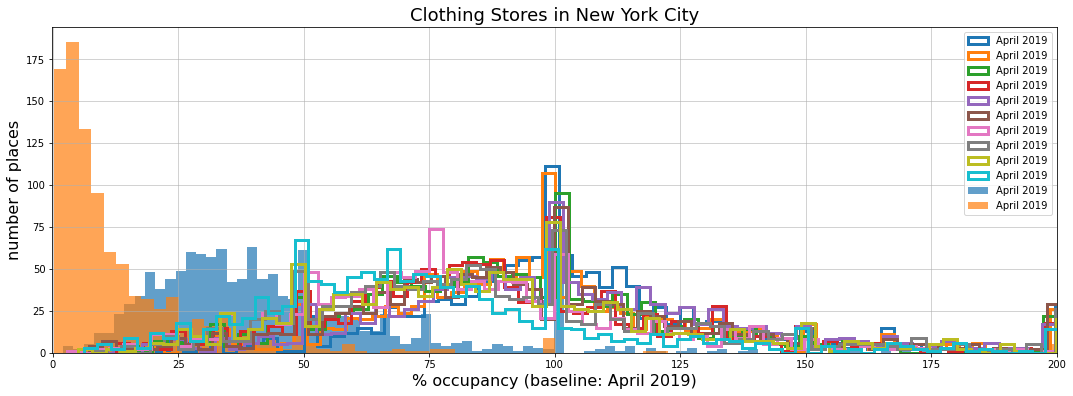

In [5]:
make_plots(dict_df_analysis, keys, place_types_list)

In [51]:
place = 'Store'
df_tmp_1 = dict_df_Seattle['2020_12'][dict_df_Seattle['2020_12']['top_category'].str.contains(place, na=False)]
df_tmp_2 = dict_df_Seattle['2020_04'][dict_df_Seattle['2019_04']['top_category'].str.contains(place, na=False)]

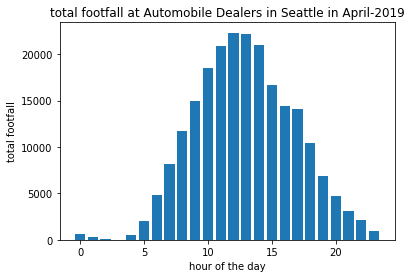

In [53]:
arr_1 = df_tmp_1['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
arr_2 = df_tmp_2['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
arr = arr_1#-arr_2
arr = arr - arr[np.argmin(arr)]
plt.bar(range(0,24), arr)
plt.ylabel('total footfall')
plt.xlabel('hour of the day')
plt.title('total footfall at Automobile Dealers in Seattle in April-2019')
plt.show()

## Seattle

In [57]:
parsedata = True
if parsedata:
    df_dict_Seattle, dfC_Seattle = getCity('WA', ['King', 'Snohomish', 'Pierce'], 'SeattleMetro')

In [23]:
keys = []
for year in ['2019', '2020']:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            keys.append(year+'_'+month)
dict_df = {}
dict_df_Seattle = {}

for key in keys:
    dict_df[key] = pd.read_csv('../datasets/SeattleMetro/SeattleMetro_'+key+'.csv.tar.gz', compression='gzip')
    
dfC_2020_04 = pd.read_csv('../datasets/SeattleMetro/Core-SeattleMetro_2020_04.csv.tar.gz', compression='gzip')

for key in keys:
    dict_df_Seattle[key] = pd.merge(dfC_2020_04[dfC_2020_04['city']=='Seattle'][['safegraph_place_id', 'top_category', 'sub_category', 'naics_code']],
                                dict_df[key][dict_df[key]['city']=='Seattle'], on='safegraph_place_id')

## Boston

In [58]:
parsedata = True
if parsedata:
    df_dict_Boston, dfC_Boston = getCity('MA', ['Suffolk', 'Middlesex'], 'Boston')

In [5]:
# plt.figure(figsize=(24,3))
# places = ['Drinking', 'Restaurant', 'Hospital', 'Office', 'Grocery', 'Clothing', 'Park']
places = ['Drinking']
dict_dist = {}

for i in range(len(places)):
#     plt.subplot(1,len(places),i+1)
    place = places[i]
    dict_dist[place] = {}
    df_tmp = dict_df_Seattle['2019_07'][dict_df_Seattle['2019_07']['top_category'].str.contains(place, na=False)]
    days = df_tmp['popularity_by_day'].apply(lambda x: literal_eval(x)).values
    factor_days = dict(functools.reduce(operator.add, map(collections.Counter, days)))
    factor_days = {key: (factor_days[key]/factor_days[max(factor_days, key=factor_days.get)]) for key in factor_days.keys()}
    for day in factor_days.keys():
        dict_dist[place][day] = {}
        
        arr = df_tmp['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
        arr = (arr - arr[np.argmin(arr)])
        arr = arr/arr[np.argmax(arr)]*100*factor_days[day]
        dict_dist[place][day] = {str(i): arr[i] for i in range(len(arr))}
#     plt.bar(range(0,24), arr, label=place)
#     plt.legend()
#     plt.grid(':', axis='y', alpha=0.6)
#     plt.xlabel('hour')
#     plt.ylabel('% crowded')

# plt.tight_layout()
# plt.show()

In [13]:
def getPopularity(place_t):
    dict_dist = {}
    dict_dist[place_t] = {}
    
    places = [place_types['place_type'][elem] for elem in translation[place_t]]

    for i in range(len(places)):
        place = re.escape(places[i])
        df_tmp = dict_df_Seattle['2019_07'][dict_df_Seattle['2019_07']['top_category'].str.contains(place, na=False)]
        if df_tmp.empty:
            print('DataFrame is empty for '+place)
            return
        try:
            np.concatenate([days, df_tmp['popularity_by_day'].apply(lambda x: literal_eval(x)).values])
        except:
            days = df_tmp['popularity_by_day'].apply(lambda x: literal_eval(x)).values
    factor_days = dict(functools.reduce(operator.add, map(collections.Counter, days)))
    factor_days = {key: (factor_days[key]/factor_days[max(factor_days, key=factor_days.get)]) for key in factor_days.keys()}
    for day in factor_days.keys():
        dict_dist[place_t][day] = {}

        arr = df_tmp['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
        arr = (arr - arr[np.argmin(arr)])
        arr = arr/arr[np.argmax(arr)]*100*factor_days[day]
        dict_dist[place_t][day] = {str(i): arr[i] for i in range(len(arr))}
    return dict_dist

In [38]:
dict_times = {}
for keys in translation.keys():
    aa = getPopularity(keys)
    dict_times.update(aa)
dict_times['creation_time_utc'] = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")

with open('popular_times.json', 'w') as f:
    json.dump(dict_times, f)

In [37]:
with open('../datasets/place_types.json', 'r') as f:
    place_types = json.load(f)

translation = {
    'amusement_park' : ['4'],
    'bars' : ['28'],
    'bakery' : ['10'],
    'beauty' : ['88'],
    'books' : ['13'],
    'car_dealer' : ['6'],
    'car_rental' : ['7'],
    'car_repair' : ['9'],
    'casino' : ['38'],
    'church' : ['96'],
    'clothing_store' : ['18'],
    'dentist' : ['71'],
    'department_store' : ['26'],
    'doctor' : ['72','73'],
    'drugs' : ['29'],
    'electronics' : ['32'],
    'florist' : ['36'],
    'funeral_home' : ['25'],
    'furniture' : ['37'],
    'gas_station' : ['39'],
    'grocery' : ['45'],
    'gym' : ['48'],
    'hair' : ['88'],
    'hospitals' : ['87', '93', '40'],
    'hotels' : ['112'],
    'insurance' : ['3'],
    'jewelry' : ['54'],
    'laundry' : ['30'],
    'liquor' : ['11'],
    'local_govt' : ['35'],
    'museum' : ['65'],
    'post_office' : ['90'],
    'rail': ['95'],
    'real_estate': ['74'],
    'restaurants': ['98'],
    'shoe_store' : ['101'],
    'store' : ['7', '8', '13', '30', '32'],
    'school' : ['33'],
    'transportation' : ['86'],
    'travel_agency' : ['111'],
    'university' : ['19', '55']
}

In [22]:
place_types['place_type']

{'0': 'Accounting, Tax Preparation, Bookkeeping, and Payroll Services',
 '1': 'Activities Related to Credit Intermediation',
 '2': 'Administration of Economic Programs',
 '3': 'Agencies, Brokerages, and Other Insurance Related Activities',
 '4': 'Amusement Parks and Arcades',
 '5': 'Apparel, Piece Goods, and Notions Merchant Wholesalers',
 '6': 'Automobile Dealers',
 '7': 'Automotive Equipment Rental and Leasing',
 '8': 'Automotive Parts, Accessories, and Tire Stores',
 '9': 'Automotive Repair and Maintenance',
 '10': 'Bakeries and Tortilla Manufacturing',
 '11': 'Beer, Wine, and Liquor Stores',
 '12': 'Beverage Manufacturing',
 '13': 'Book Stores and News Dealers',
 '14': 'Building Equipment Contractors',
 '15': 'Building Material and Supplies Dealers',
 '16': 'Child Day Care Services',
 '17': 'Clay Product and Refractory Manufacturing',
 '18': 'Clothing Stores',
 '19': 'Colleges, Universities, and Professional Schools',
 '20': 'Consumer Goods Rental',
 '21': 'Continuing Care Retireme

In [61]:
[i for i in range(4)]

[0, 1, 2, 3]